In [4]:
import numpy as np
import yfinance as yf
import pandas as pd
import scipy.optimize as sco
import matplotlib.pyplot as plt
from scipy.optimize import minimize   

tickers = ['VTI', 'AGG', 'DBC', '^VIX']


In [69]:
def get_data(tickers, window=50):
    # Télécharger les données ajustées
    data = yf.download(tickers, start="2011-01-01", end="2020-04-30", interval="1d")['Adj Close']
    
    # Supprimer les lignes avec des valeurs NaN
    data_na = data.dropna(axis=0)
    
    # Ajouter les rendements quotidiens et les décaler pour obtenir 'y'
    for column in data_na.columns:
        data_na[f'{column}_R'] = data_na[f'{column}'].pct_change()  # Rendement quotidien
        data_na[f'{column}_y'] = data_na[f'{column}_R'].shift(-1)   # Rendement décalé
    
    # Réinitialiser l'index
    data_na.reset_index(inplace=True)

    # Convertir la colonne 'Date' au format date
    data_na['Date'] = data_na['Date'].dt.date
    
    # Calcul des rendements quotidiens (sur l'ensemble des tickers)
    returns = data.pct_change().dropna()

    # Moyenne des rendements mobiles sur une fenêtre donnée
    rolling_returns = returns.rolling(window=window).mean().dropna()

    # Volatilité ex-ante avec une fenêtre mobile de 50 jours
    volatility = returns.rolling(window=window).std().dropna()

    # Retourner toutes les données
    return data_na, returns, rolling_returns, volatility

In [70]:
# Appel de la fonction
data_na, returns, rolling_returns, volatility = get_data(['VTI', 'AGG', 'DBC', '^VIX'])


[*********************100%***********************]  4 of 4 completed


In [71]:
# Paramètres
volatility_target = 0.10  
cost_rate = 0.01 
risk_free_rate = 0

In [72]:
# rendements moyens et la matrice de covariance
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

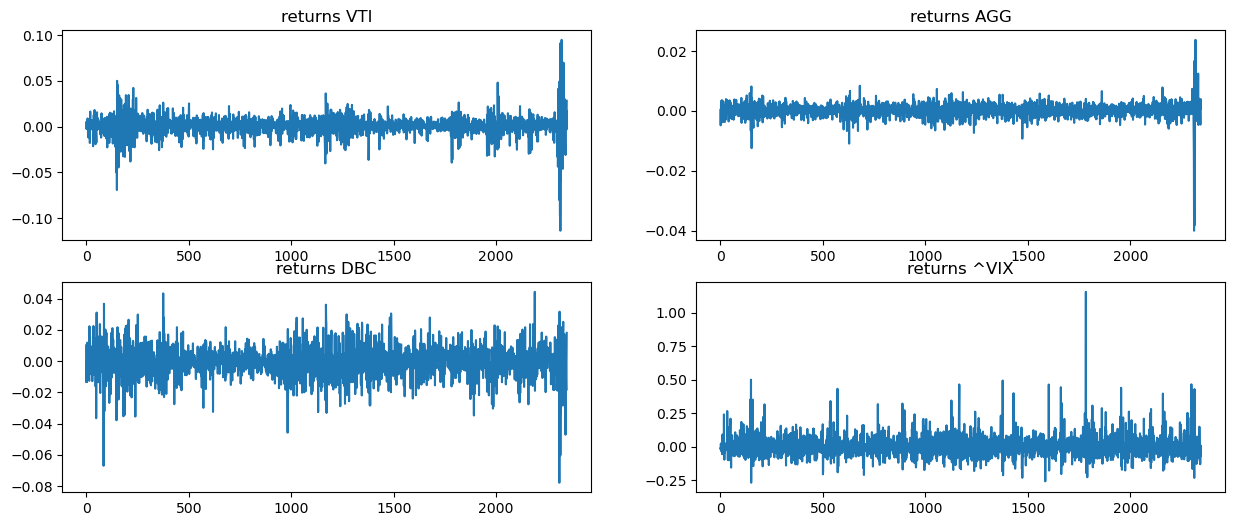

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))

axes = axes.flatten()

for i, ticker in enumerate(tickers):
    axes[i].plot(returns[ticker].values)
    axes[i].set_title(f"returns {ticker}")
plt.show()


## Mean-variance optimisation (sharpe ratio optimisation)

In [101]:
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    # Calcul du ratio de Sharpe
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe  # On minimise donc on renvoie l'inverse du Sharpe ratio

def optimize_portfolio(returns, risk_free_rate=0):
    num_assets = returns.shape[1]
    num_days = returns.shape[0]

    # Initialisation des poids égaux
    weights_init = np.ones(num_assets) / num_assets

    # Contraintes : somme des poids égale à 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bornes : chaque poids entre 0 et 1 (pas de vente à découvert)
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Stocker les poids journaliers
    weights_matrix = np.zeros((num_days, num_assets))

    # Boucle journalière pour ajuster les poids
    for day in range(num_days):
        # Moyennes et covariance jusqu'au jour actuel
        mean_returns = returns[:day+1].mean()
        cov_matrix = returns[:day+1].cov()

        # Minimisation du ratio de Sharpe (maximisation de -Sharpe)
        result = minimize(sharpe_ratio, weights_init, args=(mean_returns, cov_matrix, risk_free_rate),
                          method='SLSQP', bounds=bounds, constraints=constraints)

        # Récupérer les poids optimisés
        weights_matrix[day] = result.x

    return pd.DataFrame(weights_matrix, index=returns.index, columns=returns.columns)


In [102]:
test=optimize_portfolio(rolling_returns)

In [95]:
test

Ticker,AGG,DBC,VTI,^VIX
Date,,,,
2011-03-16 00:00:00+00:00,0.250000,2.500000e-01,0.250000,0.250000
2011-03-17 00:00:00+00:00,0.132660,4.797579e-01,0.132659,0.255264
2011-03-18 00:00:00+00:00,0.810838,1.317224e-01,0.000936,0.056529
2011-03-21 00:00:00+00:00,0.520993,1.293806e-08,0.436546,0.042462
2011-03-22 00:00:00+00:00,0.332285,0.000000e+00,0.613474,0.054242
...,...,...,...,...
2020-04-23 00:00:00+00:00,0.547153,3.434021e-15,0.401457,0.051390
2020-04-24 00:00:00+00:00,0.546943,0.000000e+00,0.401664,0.051393
2020-04-27 00:00:00+00:00,0.546782,3.791386e-16,0.401827,0.051391
